In [46]:
# Packages for analysis
import pandas as pd
import numpy as np
import pickle
import pyart
import numpy.ma as ma
from statistics import mean
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

# Loading SVM model

In [3]:
model = pickle.load(open("A3/SVM_model_file_b4.pkl", "rb"))

In [4]:
class UF:
    def __init__(self,radar,shape_grid,lat_0, lon_0):
        self.radar = radar
        self.shape_grid = shape_grid
        self.lat_0 = lat_0
        self.lon_0 = lon_0
    def remove_noises(self): #Step 3-A
        mask_noises_CC=ma.masked_less(self.radar.fields['cross_correlation_ratio']['data'],0.85)
        mask_noises_Z=ma.masked_less(self.radar.fields['reflectivity']['data'],0)
        rm_noises_Z_=np.ma.masked_array(self.radar.fields['reflectivity']['data'],mask_noises_CC.mask)
        rm_noises_Z=np.ma.masked_array(rm_noises_Z_,mask_noises_Z.mask)
        rm_noises_ZDR_=np.ma.masked_array(self.radar.fields['differential_reflectivity']['data'],mask_noises_CC.mask)
        rm_noises_ZDR=ma.masked_array(rm_noises_ZDR_,mask_noises_Z.mask)
        self.radar.add_field_like('reflectivity','Z_removed_noises',rm_noises_Z,replace_existing=True)
        self.radar.add_field_like('differential_reflectivity','ZDR_removed_noises', rm_noises_ZDR,replace_existing=True)
    def convert_grid(self):
        grid = pyart.map.grid_from_radars(
            self.radar,
            grid_shape=self.shape_grid, #Number of points in the grid (z, y, x)
            grid_limits=((0, 9000), (-100000, 100000), (-100000, 100000)), # min-max tuong duong z,y,x
            grid_origin = (self.lat_0, self.lon_0),
            fields=['Z_removed_noises',
            'ZDR_removed_noises'],
            roi_func='dist_beam',
            weighting_function='cressman')
        return grid
    def convert_lat_lon(self, grid):
        #conver distance to lat/lon
        for i in range(self.shape_grid[1]):
            geog = pyart.core.cartesian_to_geographic_aeqd(grid.x["data"][i],grid.y["data"][i],self.lon_0, self.lat_0, R=6370997.0)
            grid.x["data"][i] = geog[0]
            grid.y["data"][i] = geog[1]
        return grid
    def SHY95_algorithm(self,Zh):
        Zh.mask=0
        SHY95=np.zeros((self.shape_grid[1],self.shape_grid[2]))
        #Step 1: Intensity
        mask_st1=(Zh>=40)
        SHY95[mask_st1]=1
        #Step 2: Peakeness
        def MBG(xo,yo,n,r,Zh): #Mean Background Reflectivity
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            Zh_none_O=Zh[xo,yo]
            Zbg_ = np.ma.masked_array(Zh[mask], Zh[mask] ==Zh_none_O) # remove value cycle centers
            Zbg = np.ma.masked_array(Zbg_, Zbg_ == 0) # remove 0 values
            return Zbg
        for xo in range (0,self.shape_grid[1],1):
            for yo in range (0,self.shape_grid[2],1):
                if SHY95[xo,yo]==0:
                    Zbg=MBG(xo,yo,self.shape_grid[1],5.5,Zh).mean()
                    deltaZh=Zh[xo,yo]-Zbg
                    if (Zbg < 42.43) and (deltaZh >= (10-Zbg**2/180)):
                        SHY95[xo,yo]=1
                    elif Zbg>=42.43 and deltaZh>=0:
                        SHY95[xo,yo]=1
        #Step3: Surrounding area
        def MBG_mask_r(xo,yo,n,r,): # mask array with r change
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            return mask
        medium=[25,30,35,40]
        for xo in range (0,self.shape_grid[1],1):
            for yo in range (0,self.shape_grid[2],1):
                if SHY95[xo,yo]==1:
                    Zbg=MBG(xo,yo,self.shape_grid[1],5.5,Zh).mean()
                    if Zbg < medium[0]:
                        r=0.5 #1km
                    elif Zbg>=medium[0] and Zbg <medium[1]:
                        r=1   #2km
                    elif Zbg>=medium[1] and Zbg <medium[2]: 
                        r=1.5 #3km
                    elif Zbg>=medium[2] and Zbg <medium[3]:
                        r=2   #4km
                    elif Zbg>=medium[3]:
                        r=2.5 #5km
                    mask_st2=MBG_mask_r(xo,yo,self.shape_grid[1],r=r)
                    SHY95[mask_st2]=2
        #Step4: remaining ares as stratiform
        for q in range (0,self.shape_grid[1],1):
            for l in range (0,self.shape_grid[2],1):
                if Zh[q,l] > 0 and SHY95[q,l] !=2:
                    SHY95[q,l]=1
        return SHY95
    def SVM_algorithm(self,model,Zh_SVM,ZDR_SVM):
        SVM=np.zeros((shape_grid[1],shape_grid[2]))
        for xo in range (0,shape_grid[1],1):
            for yo in range (0,shape_grid[2],1):
                if Zh_SVM[xo,yo]!='masked' and ZDR_SVM[xo,yo]!='masked':
                    resuls=model.predict([[Zh_SVM[xo,yo], ZDR_SVM[xo,yo]]])
                    if resuls==2.0:
                        SVM[xo,yo]=2
                    elif resuls==1.0:
                        SVM[xo,yo]=1
        SVM=ma.masked_equal(SVM,0)
        return SVM
    def check_condition_BB(self,Zh_max,alg):
        index_h_BB=np.argmax(Zh_max,axis=0) # location of Zmax values in vertical(z)
        BB_array_2dB=np.zeros((self.shape_grid[1],self.shape_grid[2])) # array with BB strength > 2dB
        BB_array_5dB=np.zeros((self.shape_grid[1],self.shape_grid[2])) # array with BB strength > 5dB
        for i in range (0,self.shape_grid[1],1):
            for j in range (0,self.shape_grid[2],1):
                if index_h_BB[i,j] == 1 or index_h_BB[i,j]==2: #location of BB 1<=>3km; 2<=>4.5km; height station = 1470m
                    min_above_below=min([(Zh_max[index_h_BB[i,j],i,j]-Zh_max[index_h_BB[i,j]+1,i,j]),(Zh_max[index_h_BB[i,j],i,j]-Zh_max[index_h_BB[i,j]-1,i,j])])
                    if min_above_below >2: # conditon of BB strength >2 dB
                        BB_array_2dB[i,j]=3 
                    if min_above_below >5: # conditon of BB strength >5 dB
                        BB_array_5dB[i,j]=3
        def result(BB_array,n=0,v=0):
            for i in range (0,self.shape_grid[1],1):
                for j in range (0,self.shape_grid[2],1):
                    if BB_array[i,j]==3 and alg[i,j]==2: #SHY95: covection-2, stratiform-1, nonedatas -0 / BB_array: BB-3, noneBB-0
                        n=n+1
                    #if BB_array[i,j]==3 and YH95[i,j]==0: #SHY95: covection-2, stratiform-1, nonedatas -0 / BB_array: BB-3, noneBB-0
                    #   v=v+1
            RS_checkBB=(n/(BB_array[ BB_array == 3 ].size-v)*100)
            return RS_checkBB
        RS_2dB=result(BB_array_2dB)
        RS_5dB=result(BB_array_5dB)
        return RS_2dB,RS_5dB
y,x = np.ogrid[-50:101-50, -50:101-50]
mask = x*x + y*y > 50*50

In [5]:
SVM_2=[]
SVM_5=[]
SHY95_2=[]
SHY95_5=[]

In [6]:
Case='General'
Case_dic={Case:[*range(1,28,1)]}
for r in Case_dic[Case]:
    linkRAW='D:/data/Radars/'+Case+'/'+str(r)+'/'
    print(linkRAW)
    SVM_SB2=[]
    SVM_SB5=[]
    SHY95_SB2=[]
    SHY95_SB5=[]
    for file_name in os.listdir(linkRAW):
        radar = pyart.io.read_sigmet(linkRAW+file_name)
        lat_0 = radar.latitude['data'][0]
        lon_0 = radar.longitude['data'][0]
        shape_grid = (7, 101,101)
        UF_File = UF(radar, shape_grid, lat_0, lon_0)
        UF_File.remove_noises()
        grid = UF_File.convert_grid()
        grid_lat_lon = UF_File.convert_lat_lon(grid)
        Zh_SVM=np.ma.masked_array(grid.fields['Z_removed_noises']['data'][1,:,:],mask)
        ZDR_SVM=np.ma.masked_array(grid.fields['ZDR_removed_noises']['data'][1,:,:],mask)
        SVM=UF_File.SVM_algorithm(model,Zh_SVM,ZDR_SVM)
        Zh_check_BB=grid.fields['Z_removed_noises']['data']
        Zh_check_BB=Zh_check_BB.data
        RS_2dB_SVM,RS_5dB_SVM=UF_File.check_condition_BB(Zh_check_BB,SVM)
        SVM_SB2.append(RS_2dB_SVM)
        SVM_SB5.append(RS_5dB_SVM)
        SHY95=np.ma.masked_array(ma.masked_equal(UF_File.SHY95_algorithm(grid.fields['Z_removed_noises']['data'][1,:,:]),0.0),mask)
        RS_2dB_SHY95,RS_5dB_SHY95=UF_File.check_condition_BB(Zh_check_BB,SHY95)
        SHY95_SB2.append(RS_2dB_SHY95)
        SHY95_SB5.append(RS_5dB_SHY95)
        print(file_name)
    SVM_2.append(np.average(SVM_SB2))
    SVM_5.append(np.average(SVM_SB5))
    SHY95_2.append(np.average(SHY95_SB2))
    SHY95_5.append(np.average(SHY95_SB5))

D:/data/Radars/General/1/
PHA210208111004.RAWML7N
PHA210208112005.RAWML7X
PHA210208113004.RAWML85
PHA210208114004.RAWML8D
PHA210208115004.RAWML8M
PHA210208120004.RAWML8W
PHA210208121004.RAWML95
PHA210208122004.RAWML9D
PHA210208123004.RAWML9M
PHA210208124004.RAWML9W
PHA210208125004.RAWMLA4
PHA210208130005.RAWMLAC
PHA210208131004.RAWMLAM
PHA210208132004.RAWMLAW
PHA210208133004.RAWMLB4
PHA210208134005.RAWMLBC
PHA210208135004.RAWMLBL
PHA210208140004.RAWMLBV
D:/data/Radars/General/2/
PHA210405091004.RAWWW4F
PHA210405092004.RAWWW4P
PHA210405093004.RAWWW4Y
PHA210405094003.RAWWW56
PHA210405095004.RAWWW5E
PHA210405100004.RAWWW5N
PHA210405101004.RAWWW5Y
PHA210405102004.RAWWW66
PHA210405103004.RAWWW6E
PHA210405104004.RAWWW6N
PHA210405105004.RAWWW6X
PHA210405110004.RAWWW75
PHA210405111003.RAWWW7E
PHA210405112004.RAWWW7N
PHA210405113004.RAWWW7X
PHA210405114004.RAWWW85
PHA210405115004.RAWWW8D
PHA210405120004.RAWWW8M
PHA210405121004.RAWWW8X
PHA210405122004.RAWWW95
PHA210405123003.RAWWW9D
PHA210405124

PHA210815080004.RAWL22Y
D:/data/Radars/General/18/
PHA210815181004.RAWL2KK
PHA210815182004.RAWL2KV
PHA210815183004.RAWL2L4
PHA210815184004.RAWL2LD
PHA210815185004.RAWL2LN
PHA210815190004.RAWL2LY
PHA210815191004.RAWL2M7
PHA210815192004.RAWL2MG
PHA210815193005.RAWL2MS
PHA210815194004.RAWL2N1
PHA210815195004.RAWL2NA
PHA210815200004.RAWL2NK
PHA210815201004.RAWL2NV
PHA210815202004.RAWL2P4
PHA210815203004.RAWL2PD
PHA210815204004.RAWL2PN
PHA210815205004.RAWL2PY
PHA210815210004.RAWL2R7
D:/data/Radars/General/19/
PHA210825141004.RAW14V6
PHA210825142004.RAW14VF
PHA210825143004.RAW14VR
PHA210825144003.RAW14W0
PHA210825145004.RAW14W9
PHA210825150004.RAW14WJ
PHA210825151004.RAW14WU
PHA210825152004.RAW14X3
PHA210825153004.RAW14XC
PHA210825154003.RAW14XM
PHA210825155005.RAW14XX
PHA210825160004.RAW14Y6
D:/data/Radars/General/20/
PHA220219041004.RAWZTE9
PHA220219042004.RAWZTEJ
PHA220219043004.RAWZTEU
PHA220219044004.RAWZTF3
PHA220219045004.RAWZTFC
PHA220219050004.RAWZTFM
PHA220219051004.RAWZTFX
PHA2202

In [25]:
#results of check SHY95 algorithm by BB:
print("Sai số SHY95 với SB>2:",round(mean(SHY95_SB2),1),"%")
print("Sai số SHY95 với SB>5:",round(mean(SHY95_SB5),1),"%")

Sai số SHY95 với SB>2: 13.4 %
Sai số SHY95 với SB>5: 15.1 %


In [26]:
#results of check SVM algorithm by BB:
print("Sai số SVM với SB>2:",round(mean(SVM_SB2),1),"%")
print("Sai số SVM với SB>5:",round(mean(SVM_SB5),1),"%")

Sai số SVM với SB>2: 6.8 %
Sai số SVM với SB>5: 7.3 %


New

In [30]:
df=pd.DataFrame(data={
    'Event': list(range(1,28,1)),
    'SVM_2':SVM_2,
    'SVM_5':SVM_5,
    'SHY95_2':SHY95_2,
    'SHY95_5':SHY95_5
})

In [32]:
df.to_excel('testBB.xlsx')

In [48]:
df=pd.read_excel('testBB.xlsx')

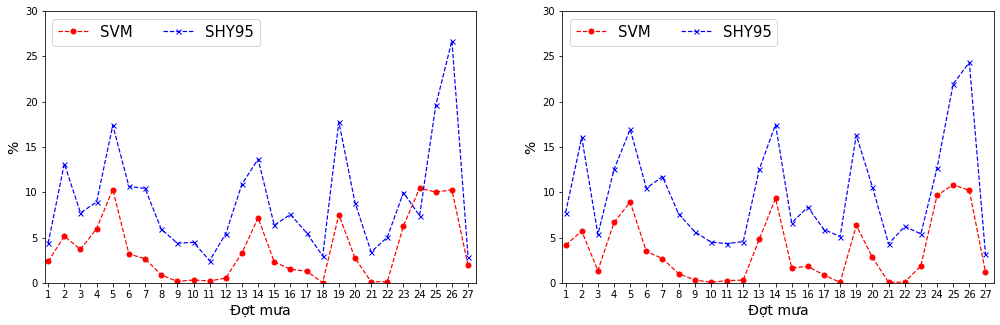

In [70]:
plt.figure(figsize=(17,5))
plt.subplot(121)
events=df['Event']
plt.plot(events,df['SVM_2'], linewidth=1.2,color='red', label="SVM",marker='o',markersize = 5,linestyle="--")
plt.plot(events,df['SHY95_2'], linewidth=1.2,color='blue', label="SHY95",marker='x',markersize = 5,linestyle="--")
plt.ylim([0.,30])
plt.xlim([0.8,27.5])
plt.ylabel('%',fontsize=14)
plt.xlabel('Đợt mưa',fontsize=14)
plt.grid(False)
plt.legend(loc='upper left', ncol=2,fontsize=15)
plt.xticks(np.arange(1, 28, step=1));
#plt.yticks(np.arange(0, 35, 5))
plt.subplot(122)
events=df['Event']
plt.plot(events,df['SVM_5'], linewidth=1.2,color='red', label="SVM",marker='o',markersize = 5,linestyle="--")
plt.plot(events,df['SHY95_5'], linewidth=1.2,color='blue', label="SHY95",marker='x',markersize = 5,linestyle="--")
plt.ylim([0.,30])
plt.xlim([0.8,27.5])
plt.xlabel('Đợt mưa',fontsize=14)
plt.ylabel('%',fontsize=14)
plt.grid(False)
plt.legend(loc='upper left', ncol=2,fontsize=15)
plt.xticks(np.arange(1, 28, step=1));
#plt.yticks(np.arange(0, 35, 5))

In [1]:
#Đánh giá

In [ ]:
Case='General'
Case_dic={Case:[*range(1,28,1)]}
for r in Case_dic[Case]:
    linkRAW='D:/data/Radars/'+Case+'/'+str(r)+'/'
    print(linkRAW)
    SVM_S=[]
    SVM_C=[]
    SHY95_S=[]
    SHY95_C=[]
    for file_name in os.listdir(linkRAW):
        radar = pyart.io.read_sigmet(linkRAW+file_name)
        lat_0 = radar.latitude['data'][0]
        lon_0 = radar.longitude['data'][0]
        shape_grid = (7, 201,101)
        UF_File = UF(radar, shape_grid, lat_0, lon_0)
        UF_File.remove_noises()
        grid = UF_File.convert_grid()
        grid_lat_lon = UF_File.convert_lat_lon(grid)
        Zh_SVM=np.ma.masked_array(grid.fields['Z_removed_noises']['data'][1,:,:],mask)
        ZDR_SVM=np.ma.masked_array(grid.fields['ZDR_removed_noises']['data'][1,:,:],mask)
        SVM=UF_File.SVM_algorithm(model,Zh_SVM,ZDR_SVM)
        SHY95=np.ma.masked_array(ma.masked_equal(UF_File.SHY95_algorithm(grid.fields['Z_removed_noises']['data'][1,:,:]),0.0),mask)
        print(file_name)
    SVM_2.append(np.average(SVM_SB2))
    SVM_5.append(np.average(SVM_SB5))
    SHY95_2.append(np.average(SHY95_SB2))
    SHY95_5.append(np.average(SHY95_SB5))